# Classification of blood-brain-barrier permeability data

**Input data**: Simplified Molecular Input Line Entry System (SMILES) strings as molecular descriptors converted to feature embeddings with ChemBERTa-2.

In [1]:
from os.path import join
from collections import Counter

import numpy as np
import pandas as pd
import h5py
from pandas import HDFStore

from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
import seaborn as sns

from molecule_gym.config import DATA_DIR, RESULTS_DIR
from molecule_gym.core.classifiers import classify_binary_data
from molecule_gym.core.visualizations import plot_explained_variance

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Importing the raw dataset

Loading the raw dataset into a dataframe.

In [2]:
h5file = HDFStore(join(DATA_DIR, 'chemberta2_blood_brain_barrier_permeability.h5'), mode='r')

In [3]:
h5file.keys()

['/bbbp_raw']

In [4]:
data = h5file.get('/bbbp_raw')

In [5]:
h5file.close()

In [6]:
data.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [7]:
data.shape

(2050, 4)

In [8]:
labels = data['p_np']
labels.value_counts()

1    1567
0     483
Name: p_np, dtype: int64

## Load numeric feature embeddings of SMILES strings generated with ChemBERTa-2

In [9]:
f = h5py.File(join(DATA_DIR, 'chemberta2_blood_brain_barrier_permeability.h5'), 'r')

In [10]:
f.keys()

<KeysViewHDF5 ['bbbp_raw', 'chemberta_2_features']>

In [11]:
features = f.get('chemberta_2_features')

In [12]:
features.shape

(2050, 7924)

In [13]:
# Distribution description of a feature sample
features_describe = pd.DataFrame(features[0,:])
features_describe.describe()

,0
count,7924.000000
mean,-6.741820
std,1.530230
min,-10.536302
25%,-7.563511
50%,-6.983957
75%,-6.325683
max,7.956779


## Binary classification with embeddings data

In [14]:
features.shape

(2050, 7924)

In [15]:
labels.value_counts()

1    1567
0     483
Name: p_np, dtype: int64

In [16]:
labels[:966].value_counts()

1    483
0    483
Name: p_np, dtype: int64

Training target statistics: Counter({0: 341, 1: 335})
Testing target statistics: Counter({1: 148, 0: 142})
Using SVC classifier

Model performance on training data:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       341
           1       0.75      0.83      0.79       335

    accuracy                           0.78       676
   macro avg       0.78      0.78      0.78       676
weighted avg       0.78      0.78      0.78       676


Model performance on test data:
              precision    recall  f1-score   support

           0       0.82      0.72      0.76       142
           1       0.76      0.84      0.80       148

    accuracy                           0.78       290
   macro avg       0.79      0.78      0.78       290
weighted avg       0.79      0.78      0.78       290



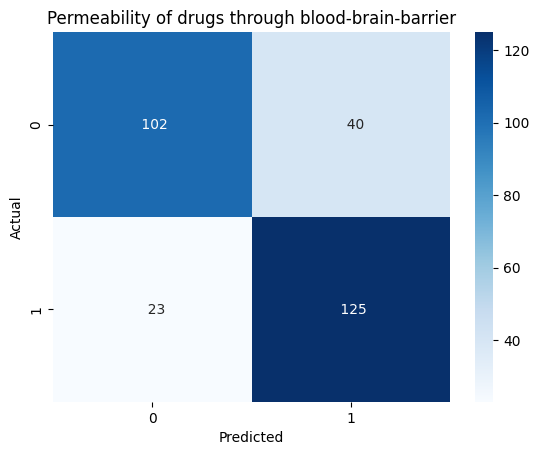

In [17]:
classify_binary_data(features[:966, :], labels[:966])

## Feature reduction with PCA Analysis

In [18]:
pca = PCA()

In [19]:
features_transformed = pca.fit_transform(features)

In [20]:
exp_var_pca = pca.explained_variance_ratio_[:20]
exp_var_pca

array([0.5938465 , 0.10870522, 0.07596859, 0.03343878, 0.02153103,
       0.01561497, 0.01211777, 0.01090148, 0.00931212, 0.00752243,
       0.00695139, 0.00620874, 0.00573067, 0.00467514, 0.00443109,
       0.00391127, 0.00385056, 0.00366863, 0.00342663, 0.00282674],
      dtype=float32)

In [21]:
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
cum_sum_eigenvalues

array([0.5938465 , 0.7025517 , 0.7785203 , 0.8119591 , 0.83349013,
       0.8491051 , 0.86122286, 0.8721243 , 0.8814364 , 0.8889588 ,
       0.8959102 , 0.9021189 , 0.9078496 , 0.91252476, 0.9169558 ,
       0.9208671 , 0.92471766, 0.9283863 , 0.9318129 , 0.93463963],
      dtype=float32)

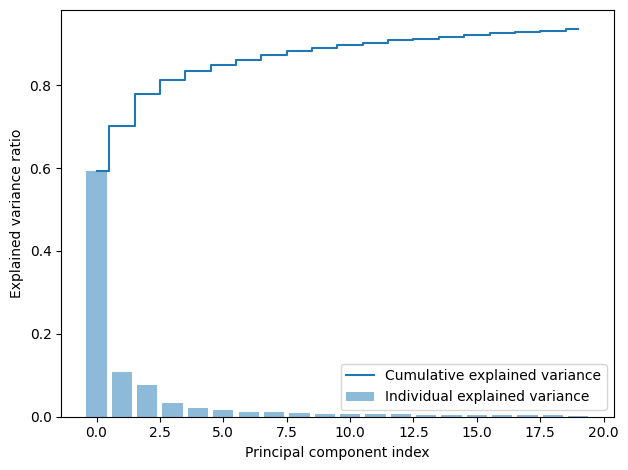

In [22]:
plot_explained_variance(exp_var_pca)

In [23]:
features_reduced = features_transformed[:,:20]

In [24]:
features_reduced.shape

(2050, 20)

Training target statistics: Counter({1: 340, 0: 336})
Testing target statistics: Counter({0: 147, 1: 143})
Using SVC classifier

Model performance on training data:
              precision    recall  f1-score   support

           0       0.85      0.68      0.75       336
           1       0.73      0.89      0.80       340

    accuracy                           0.78       676
   macro avg       0.79      0.78      0.78       676
weighted avg       0.79      0.78      0.78       676


Model performance on test data:
              precision    recall  f1-score   support

           0       0.83      0.65      0.73       147
           1       0.70      0.87      0.78       143

    accuracy                           0.76       290
   macro avg       0.77      0.76      0.75       290
weighted avg       0.77      0.76      0.75       290



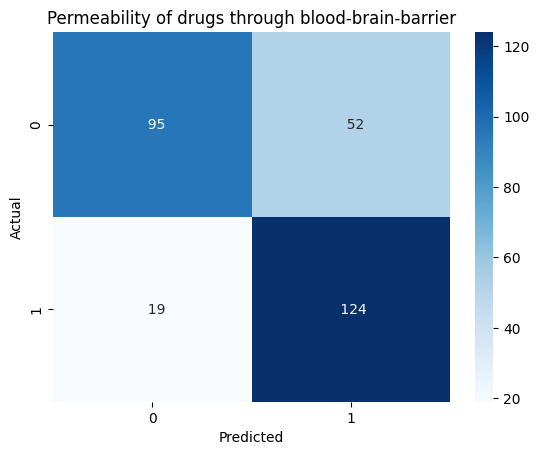

In [25]:
classify_binary_data(features_reduced[:966, :], labels[:966])

## Oversampling the smallest class

In [26]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(features_reduced, labels)

In [27]:
print(X_res.shape, y_res.shape)

(3134, 20) (3134,)


Training target statistics: Counter({1: 1110, 0: 1083})
Testing target statistics: Counter({0: 484, 1: 457})
Using SVC classifier

Model performance on training data:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1083
           1       0.88      0.84      0.86      1110

    accuracy                           0.86      2193
   macro avg       0.86      0.86      0.86      2193
weighted avg       0.86      0.86      0.86      2193


Model performance on test data:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       484
           1       0.84      0.80      0.82       457

    accuracy                           0.83       941
   macro avg       0.83      0.83      0.83       941
weighted avg       0.83      0.83      0.83       941



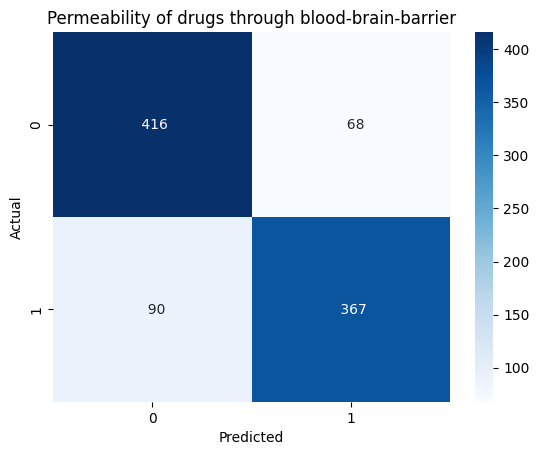

In [28]:
classify_binary_data(X_res, y_res)

## Pycaret pipeline for classification

In [29]:
from pycaret.classification import *

In [30]:
reduced_data = pd.DataFrame(X_res)
reduced_data['labels'] = y_res

In [31]:
reduced_data.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-74.167587,-0.996756,7.954123,-10.170083,-9.089236,0.543555,12.341965,0.624062,2.688728,-1.458065,...,-7.552795,5.322787,0.619413,-8.618954,-3.480988,-0.400625,1.117439,-1.061518,-4.796038,1
1,92.225037,42.419735,4.716671,24.825651,-37.279255,-3.626776,1.437448,2.698268,2.054265,6.807059,...,1.629251,-3.775596,-8.851215,0.914740,4.299535,-13.252625,3.122720,-2.901517,-0.668159,1
2,-31.415817,-17.568005,-29.415537,4.012112,-3.580359,8.638283,-4.589925,-13.917303,-0.626637,12.066761,...,4.960220,4.564825,2.261058,-4.861485,-9.279594,1.337490,3.126763,-1.087729,-0.588485,1
3,-75.985245,3.011175,17.944036,17.009014,-8.112281,11.603303,2.847257,3.253739,7.401922,7.330302,...,-7.301838,-0.741727,-8.923892,4.528469,3.458456,-1.959076,-0.213407,2.972574,0.245770,1
4,-2.505742,1.356949,-32.659760,-3.806558,2.829599,2.198839,-8.433534,-11.375056,-4.505994,6.733484,...,-2.938817,5.512522,-2.902334,-2.648396,-1.194102,3.019176,-7.291344,5.654909,-1.800486,1


In [32]:
exp_clf101 = setup(data=reduced_data, target='labels',
                   fold_strategy='kfold', fold_shuffle=True,
                   #fix_imbalance=True, fix_imbalance_method='SMOTE',
                   normalize=False,# normalize_method='robust',
                   remove_multicollinearity=False,# multicollinearity_threshold=0.9,
                   experiment_name='bbbp_classifier',
                   memory=RESULTS_DIR, profile=True,
                   session_id=69763)

,Description,Value
0,Session id,69763
1,Target,labels
2,Target type,Binary
3,Original data shape,"(3134, 21)"
4,Transformed data shape,"(3134, 21)"
5,Transformed train set shape,"(2193, 21)"
6,Transformed test set shape,"(941, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


Loading profile... Please Wait!
Profiler Failed. No output to show, continue with modeling.


In [33]:
top_n = compare_models(sort='F1', n_select=2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9576,0.9880,0.9609,0.9547,0.9577,0.9150,0.9152,0.0510
rf,Random Forest Classifier,0.9462,0.9861,0.9376,0.9547,0.9459,0.8922,0.8927,0.0480
lightgbm,Light Gradient Boosting Machine,0.9334,0.9799,0.9050,0.9596,0.9312,0.8665,0.8683,0.0320
gbc,Gradient Boosting Classifier,0.9020,0.9575,0.8510,0.9491,0.8964,0.8037,0.8095,0.0310
dt,Decision Tree Classifier,0.8910,0.8913,0.8350,0.9418,0.8848,0.7819,0.7875,0.0230
ada,Ada Boost Classifier,0.8226,0.8959,0.7965,0.8411,0.8170,0.6451,0.6477,0.0300
knn,K Neighbors Classifier,0.8331,0.9144,0.7358,0.9148,0.8146,0.6658,0.6798,0.0900
qda,Quadratic Discriminant Analysis,0.8003,0.8969,0.7512,0.8341,0.7895,0.6006,0.6048,0.0210
lr,Logistic Regression,0.7770,0.8718,0.7548,0.7912,0.7714,0.5544,0.5566,0.2660
ridge,Ridge Classifier,0.7679,0.0000,0.7167,0.7995,0.7549,0.5361,0.5403,0.0180


### Fine tuning best model

In [34]:
best_model = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9727,0.9799,0.9906,0.9545,0.9722,0.9455,0.9461
1,0.9409,0.9727,0.9643,0.9231,0.9432,0.8817,0.8826
2,0.9545,0.9870,0.9633,0.9459,0.9545,0.9091,0.9092
3,0.9726,0.9906,0.9658,0.9826,0.9741,0.9450,0.9452
4,0.9498,0.9929,0.9364,0.9626,0.9493,0.8996,0.8999
5,0.9635,0.9913,0.9737,0.9569,0.9652,0.9268,0.9269
6,0.9406,0.9844,0.9322,0.9565,0.9442,0.8808,0.8811
7,0.9452,0.9912,0.9394,0.9394,0.9394,0.8894,0.8894
8,0.9635,0.9932,0.9727,0.9554,0.9640,0.9269,0.9271


In [35]:
tuned_model = tune_model(best_model, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8818,0.9448,0.9245,0.8448,0.8829,0.7641,0.7673
1,0.8409,0.9208,0.8393,0.8468,0.8430,0.6818,0.6818
2,0.8545,0.9374,0.8807,0.8348,0.8571,0.7092,0.7103
3,0.8447,0.9354,0.7949,0.9029,0.8455,0.6908,0.6964
4,0.8584,0.9227,0.8636,0.8559,0.8597,0.7169,0.7169
5,0.8630,0.9404,0.8684,0.8684,0.8684,0.7256,0.7256
6,0.8493,0.9112,0.8051,0.9048,0.8520,0.6996,0.7045
7,0.8402,0.9322,0.8283,0.8200,0.8241,0.6777,0.6777
8,0.8904,0.9518,0.8909,0.8909,0.8909,0.7808,0.7808


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


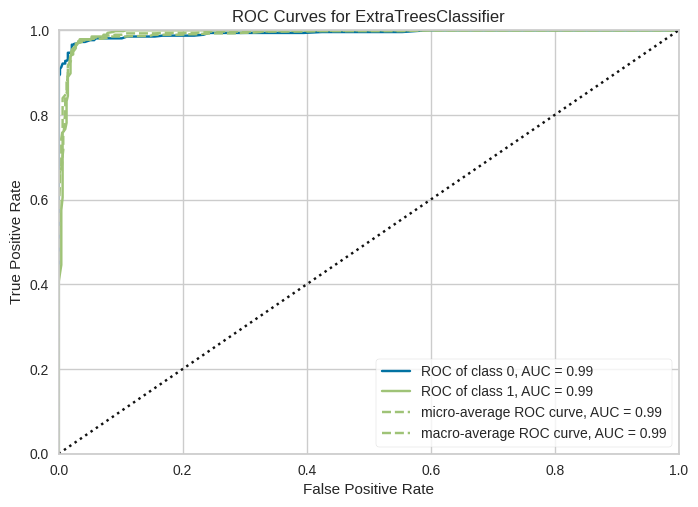

In [36]:
plot_model(tuned_model, plot = 'auc')#, save=True)

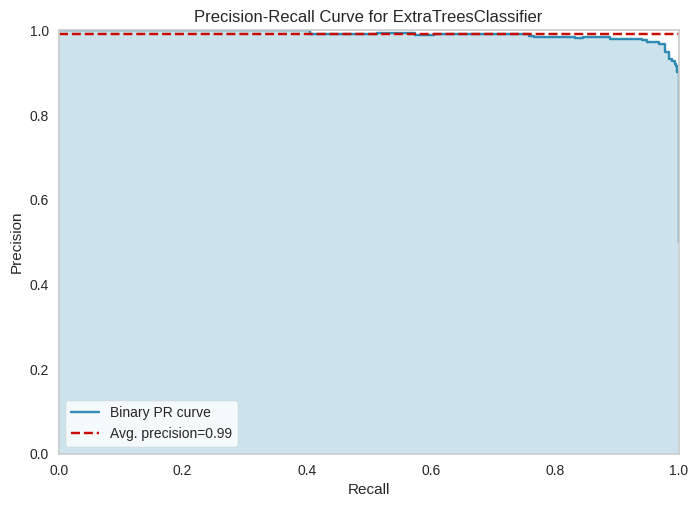

In [37]:
plot_model(tuned_model, plot = 'pr')#save=True

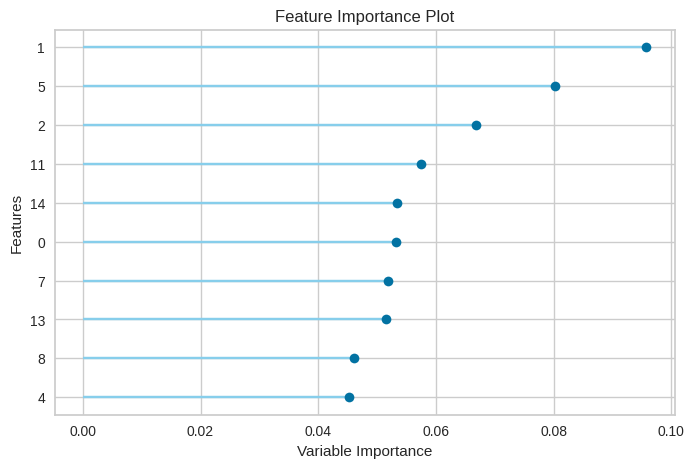

In [38]:
plot = plot_model(tuned_model, plot='feature')#save=True

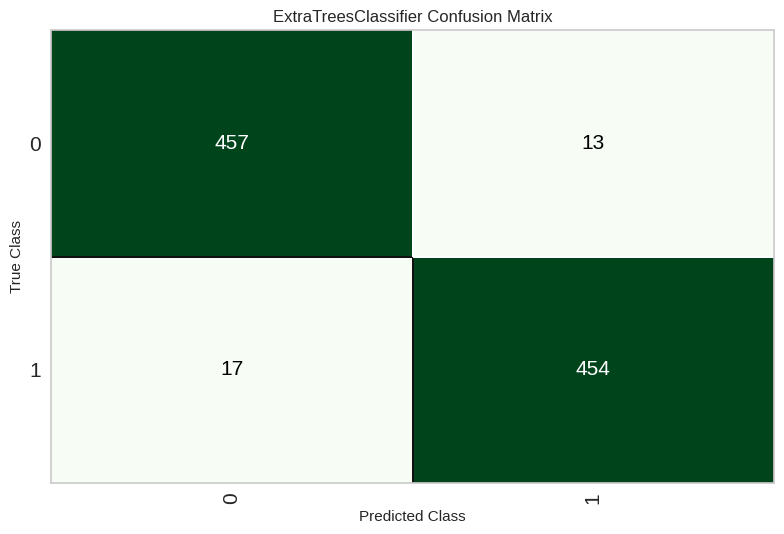

In [39]:
plot_model(tuned_model, plot = 'confusion_matrix')#save=True

In [40]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [41]:
final_model = finalize_model(tuned_model)
#print(final_model)